In [1]:
import pickle
import re
import string
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import OneClassSVM
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load Dataset
dataset = pd.read_csv('Datasets/Text Classification/Emotion_final.csv')
dataset.tail()

,Text,Emotion
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear
21458,"I am dismayed , but not surpris",fear


In [3]:
dataset = shuffle(dataset)
dataset.reset_index(inplace=True, drop=True)
dataset.tail()

,Text,Emotion
21454,i feel like im not welcomed here i just dont l...,happy
21455,a girl entered in the division where i work an...,anger
21456,i cant help but feel excited for the part wher...,happy
21457,i feel tat all of us in this world are clever ...,happy
21458,i feel quite rebellious actually,anger


In [4]:
# sns.countplot(dataset.Emotion)
# plt.show()

In [5]:
encoder = LabelEncoder()
dataset['Label'] = encoder.fit_transform(dataset['Emotion'])
dataset.head()

,Text,Emotion,Label
0,i feel beaten a href http ediebloom,sadness,4
1,i wish there was something i could do sitting ...,fear,1
2,i feel strangely carefree and free from all bu...,happy,2
3,i just feel weird doing it but i want to make ...,fear,1
4,i tend to be a window shopper when im alone be...,love,3


In [6]:
def cleaning_text(text):
    text = text.lower()
    text = re.sub('r<.*?>', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'http\S+', " ", text)

    text = text.split()
    stop_words = stopwords.words("english")
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")

    return text

In [7]:
dataset['Text'] = dataset['Text'].apply(lambda x: cleaning_text(x))

In [8]:
# Dictionary length
num_classes = dataset.Label.nunique()
res = Counter()
dataset['Text'].str.split().apply(res.update)
dim_dic = len(res.keys())

# Maximum sentence length
max_len_words = max(list(dataset['Text'].apply(len)))

In [9]:
cv = CountVectorizer(ngram_range=(1, 2))

In [10]:
cv_texts = cv.fit_transform(dataset.Text)
X_train, X_val, y_train, y_val = train_test_split(cv_texts, dataset.Label,
                                                  test_size=.2, shuffle=True,
                                                  stratify=dataset.Label, random_state=3)

In [11]:
ab = OneVsRestClassifier(AdaBoostClassifier())
ab.fit(X_train, y_train)
ab_predict = ab.predict(X_val)
print("Accuracy: ", accuracy_score(y_val, ab_predict))

Accuracy:  0.7460391425908667


<AxesSubplot: >

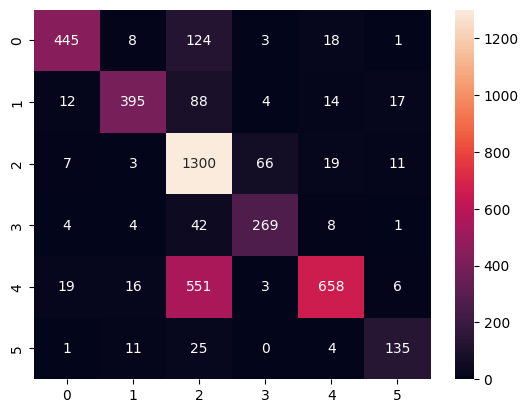

In [12]:
sns.heatmap(confusion_matrix(y_val, ab_predict), annot=True, fmt="d")

In [13]:
print(classification_report(y_val, ab_predict, digits=3))

              precision    recall  f1-score   support

           0      0.912     0.743     0.819       599
           1      0.904     0.745     0.817       530
           2      0.610     0.925     0.735      1406
           3      0.780     0.820     0.799       328
           4      0.913     0.525     0.667      1253
           5      0.789     0.767     0.778       176

    accuracy                          0.746      4292
   macro avg      0.818     0.754     0.769      4292
weighted avg      0.797     0.746     0.744      4292



In [14]:
clf = OneVsRestClassifier(svm.SVC())
clf.fit(X_train, y_train)
clf_predict = clf.predict(X_val)
print("Accuracy: ", accuracy_score(y_val, clf_predict))

Accuracy:  0.8473904939422181


<AxesSubplot: >

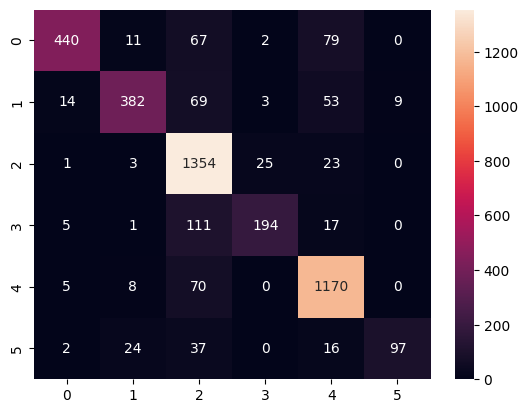

In [15]:
sns.heatmap(confusion_matrix(y_val, clf_predict), annot=True, fmt="d")

In [16]:
print(classification_report(y_val, clf_predict, digits=3))

              precision    recall  f1-score   support

           0      0.942     0.735     0.826       599
           1      0.890     0.721     0.797       530
           2      0.793     0.963     0.870      1406
           3      0.866     0.591     0.703       328
           4      0.862     0.934     0.896      1253
           5      0.915     0.551     0.688       176

    accuracy                          0.847      4292
   macro avg      0.878     0.749     0.796      4292
weighted avg      0.856     0.847     0.842      4292



In [17]:
tokenizer = Tokenizer(num_words=dim_dic)
tokenizer.fit_on_texts(dataset.Text)

def tokenize_split(x_train, y_train):
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train,
                                                      test_size=.1, shuffle=True,
                                                      stratify=y_train, random_state=42)

    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_words,
                                 truncating='post',
                                 padding='post')

    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                               maxlen=max_len_words,
                               truncating='post',
                               padding='post', )

    return train_padded, val_padded, y_train, y_val

In [18]:
X_train, X_val, y_train, y_val = tokenize_split(dataset.Text, dataset.Label)

In [25]:
model = Sequential([
    layers.Embedding(dim_dic, 100, input_length=max_len_words),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0)),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 232, 100)          1911700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 232, 128)         84480     
 nal)                                                            
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [29]:
start = time.perf_counter()
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         mode="min", patience=3)


history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    shuffle=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/10
604/604 [==============================] - 68s 112ms/step - loss: 0.0814 - accuracy: 0.9713 - val_loss: 0.3077 - val_accuracy: 0.9087
Epoch 2/10
604/604 [==============================] - 74s 123ms/step - loss: 0.0670 - accuracy: 0.9768 - val_loss: 0.3258 - val_accuracy: 0.9040
Epoch 3/10
604/604 [==============================] - 75s 124ms/step - loss: 0.0541 - accuracy: 0.9814 - val_loss: 0.3891 - val_accuracy: 0.9068
Epoch 4/10
604/604 [==============================] - 75s 124ms/step - loss: 0.0549 - accuracy: 0.9822 - val_loss: 0.3946 - val_accuracy: 0.9101
Elapsed 293.226 seconds.


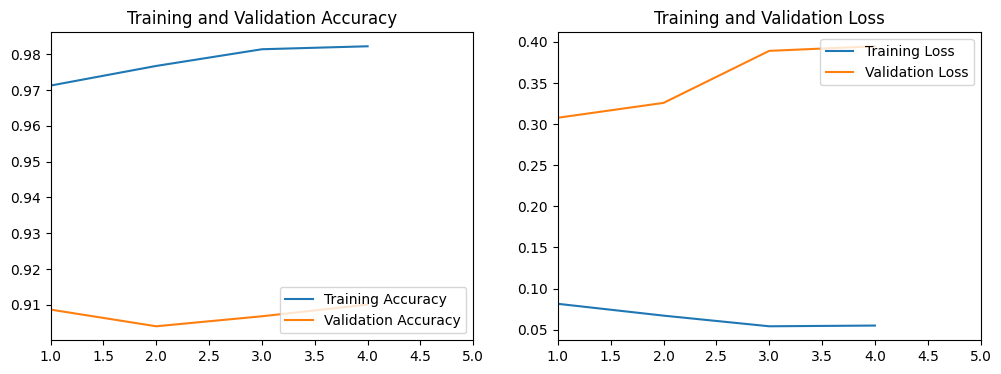

In [30]:
# Plotting accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_acc) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc) + 1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc) + 1)
plt.title('Training and Validation Loss')
plt.show()